<a href="https://www.kaggle.com/code/rafaelgardel/starbucks-reviews-eda-nlp-and-ml-with-79-acc?scriptVersionId=144903490" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
"Importing the libraries"

import pandas as pd
import numpy as np
import nltk
# !pip install -U spacy
import spacy
spacy.cli.download("en_core_web_sm")
import string
import plotly.express as px
from joblib import dump, load
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 1. Importing and Preprocessing the Data

In [2]:
df = pd.read_csv('database/reviews_data.csv')

def lemmatize_words(text, nlp):
    "Lemmatizes a list of words."

    doc = nlp(text)

    lemmatized_words = [token.lemma_ for token in doc]

    return lemmatized_words

def remove_punctuation_and_digits(review):
    '''Remove the punctuation and the digits from the review'''
    
    review = str(review)
    review = "".join(
        [char for char in review if char not in string.punctuation and char not in string.digits])
    return review

df = df[['Rating', 'Review']]

# Only rows where Rating and Review are not null will be considered.
df=df[(df['Rating'].isna()==False) & (df['Review'].isna()==False)]

df['Rating'] = df['Rating'].astype(int)
df['Review'] = df['Review'].astype('str')

# Convert all comments to lowercase.
df['Review'] = df['Review'].str.lower()

# Remove the punctuation and the digits from the review
df['Review'] = df['Review'].apply(lambda x: remove_punctuation_and_digits(x))

# Lemmatizes the Review column
nlp = spacy.load("en_core_web_sm")

df['Review'] = df['Review'].apply(
    lambda x: " ".join(lemmatize_words(x, nlp)))

def get_sentiment(column):
    '''Get the sentiment from the review'''
    
    sia = SentimentIntensityAnalyzer()
        
    column_polarity_scores = [sia.polarity_scores(text) for text in column]
    column_sentiment_scores = []

    for index, scores in enumerate(column_polarity_scores):
        
        if scores['pos']>scores['neg'] + scores['neu']:
            pol = 'Positive'
            
        elif scores['neg']>scores['pos'] + scores['neu']:
            pol = 'Negative'
            
        else:
            pol = 'Neutral'
            
        column_sentiment_scores.append(pol)
        
    return column_sentiment_scores

df['Sentiment'] = get_sentiment(df['Review'])

df.drop_duplicates(keep='last', inplace=True, ignore_index=True)

df.reset_index()

df.head()

,Rating,Review,Sentiment
0,5,amber and ladonna at the starbuck on southwest...,Neutral
1,5,at the starbuck by the fire station on in ...,Neutral
2,5,I just want to go out of my way to recognize a...,Neutral
3,5,I and my friend be at starbuck and my card do ...,Neutral
4,5,I ’m on this kick of drinking cup of warm wa...,Neutral


## 2. Evaluating the data

### 2.1 Assessing data distribution

In [3]:
df_grouped = df.groupby('Rating').count()['Review'].reset_index()
df_grouped['Rating'] = df_grouped['Rating'].astype(str)

fig = px.bar(df_grouped, x='Rating', y='Review', text='Review', color='Rating', title='Count of Reviews by Rating')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.show()

Note that most of the reviews have a rating equal to 1, indicating a highly imbalanced dataset.

In [4]:
# Evaluating the correlation between the number of words in the comment and the Rating.
df['Qty_of_words'] = [len(x) for x in df['Review']]

print(df[['Rating', 'Qty_of_words']].corr().round(2),'\n')

correlation, p_value = pearsonr(df['Qty_of_words'], df['Rating'])

print(f'correlation between Qty_of_words and Rating: {correlation:.2f}, p-value: {p_value:.4f}')

              Rating  Qty_of_words
Rating          1.00         -0.32
Qty_of_words   -0.32          1.00 

correlation between Qty_of_words and Rating: -0.32, p-value: 0.0000


The Pearson correlation analysis revealed a statistically significant negative relationship (correlation of approximately -0.32, p-value < 0.0001) between the number of words in a dataset ('Qty_of_words') and the associated rating ('Rating'). This suggests that, on average, as the number of words increases, the rating tends to decrease, which could be a relevant finding for understanding the dataset dynamics and influencing future analyses or decision-making.

In [5]:
# Evaluating the relationship between the number of words, Rating, and the Rating.
px.scatter(df, x='Qty_of_words', y='Rating', color="Rating",
           color_continuous_scale=["red", "green", "blue"])

In [6]:
# Evaluating the relationship between the number of words and the Rating.
px.histogram(df.sort_values(by='Rating'), x='Qty_of_words', color="Rating", facet_row='Rating')

In [7]:
px.scatter(df, x='Rating', size='Qty_of_words',
              y='Qty_of_words', color='Rating')

In [8]:
# Evaluating the relationship between the number of words and the Rating.
px.histogram(df.sort_values(by='Rating'), x='Qty_of_words', color="Sentiment", facet_row='Rating')

### 2.2. Evaluating the vocabulary

In [9]:
stopWords = nltk.corpus.stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stopWords)
bag_of_words = vectorizer.fit_transform(df['Review'].tolist())

print(f'Vocabulary size {len(vectorizer.vocabulary_)}\n')

# the 5 elements with the highest appearances
highest_appearances = dict(sorted(
    vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True)[:5])

print("5 elements with the highest appearances:")
print(highest_appearances, '\n')

print(f'Appearances per word: {vectorizer.vocabulary_}\n')

Vocabulary size 4077

5 elements with the highest appearances:
{'zitface': 4076, 'zero': 4075, 'zeeb': 4074, 'yummy': 4073, 'yukon': 4072} 

Appearances per word: {'amber': 129, 'ladonna': 1945, 'starbuck': 3380, 'southwest': 3321, 'parkway': 2533, 'always': 125, 'warm': 3931, 'welcome': 3968, 'smile': 3265, 'voice': 3905, 'greet': 1548, 'drivethru': 1083, 'customer': 862, 'service': 3157, 'spoton': 3361, 'get': 1495, 'order': 2465, 'right': 2990, 'would': 4040, 'actually': 48, 'give': 1503, 'star': 3379, 'available': 255, 'fire': 1347, 'station': 3391, 'altamonte': 120, 'spring': 3364, 'fl': 1359, 'make': 2094, 'day': 890, 'finally': 1342, 'help': 1640, 'figure': 1334, 'way': 3948, 'drink': 1073, 'love': 2063, 'take': 3525, 'time': 3622, 'talk': 3527, 'minute': 2211, 'experience': 1252, 'well': 3970, 'use': 3826, 'much': 2280, 'appreciated': 181, 'bad': 281, 'one': 2443, 'another': 154, 'close': 652, 'work': 4029, 'building': 462, 'great': 1543, 'along': 115, 'specific': 3338, 'barist

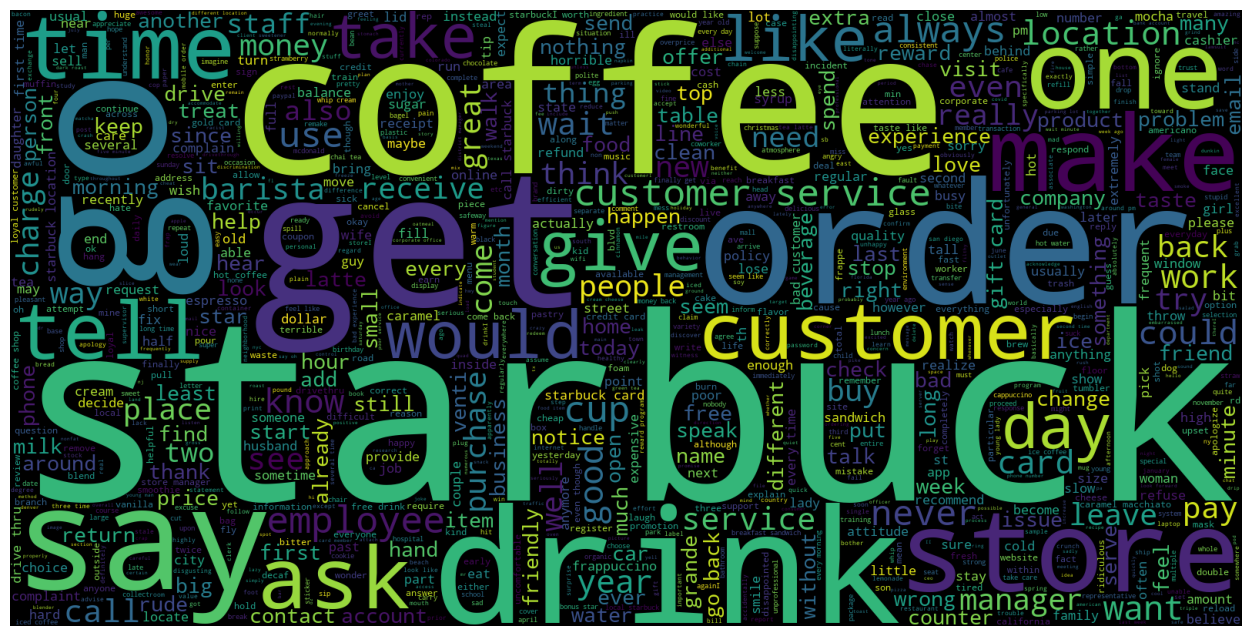

In [10]:
# Combining all comments to build the word cloud.
all_comments = "".join(comment for comment in df['Review'])

# Instantiating the word cloud.
wordcloud = WordCloud(stopwords=stopWords,
                      background_color='black', width=1600,
                      height=800, max_words=1000,  max_font_size=500,
                      min_font_size=1).generate(all_comments)  # mask=mask,

# Whe wordcloud
fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

## 3. Training the Models

Testing various models while simultaneously performing feature selection (ANOVA F-value) with varying numbers of features (words) is a valuable approach. It helps answer important questions such as whether the variation in the number of features affects the results, which model performs best, what its accuracy is, and what the ideal number of words is. This systematic analysis will allow you to identify the most effective model, assess its accuracy, and determine the optimal number of words for your specific dataset and task, ultimately leading to more informed decisions in your data analysis process.

In [11]:
models={
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(),
    'RidgeClassifier': RidgeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    'SVC': SVC(),
    'LinearSVC': LinearSVC(),
    'KNeighborsClassifier': KNeighborsClassifier(),
}

results = {'best_acuracy': -np.inf,
           'best_model': 0,
        'best_features' : np.zeros(df['Review'].shape[0]),
        'best_acuracy_evolution' : [],
        'n_features_evolution' : [],
        'improvements' : []
       }

vectorizer = TfidfVectorizer(stop_words=stopWords, analyzer = 'word')
X = vectorizer.fit_transform(df['Review']).toarray()
y = df['Rating']

for n_features in np.arange(100, X.shape[1], 100):
    
    selector = SelectKBest(f_classif, k=n_features)
    X_selected = selector.fit_transform(X, y)
    
    X_train, X_test, y_train, y_test=train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=30)
    
    improvement = False

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        if accuracy>results['best_acuracy']:
            improvement=True
            results['improvements'].append(improvement)
            results['best_acuracy'] = accuracy
            results['best_model'] = model
            results['best_features'] = X_selected
            results['best_acuracy_evolution'].append(results['best_acuracy'])
            results['n_features_evolution'].append(n_features)
            
    if improvement:
        print(f'n_features: {n_features}:{round(n_features/X.shape[1],2)} ')
        print('Accuracy score of best model:', results['best_acuracy'],'\n')
    
    else:        
        results['improvements'].append(improvement)
        results['n_features_evolution'].append(n_features)
        results['best_acuracy_evolution'].append(results['best_acuracy'])
        
        print(f'n_features: {n_features}:{round(n_features/X.shape[1],2)} ')
        print('Best accuracy not improved', results['best_acuracy'],'\n')

n_features: 100:0.02 
Accuracy score of best model: 0.7092198581560284 

n_features: 200:0.05 
Accuracy score of best model: 0.723404255319149 

n_features: 300:0.07 
Accuracy score of best model: 0.7304964539007093 

n_features: 400:0.1 
Accuracy score of best model: 0.7375886524822695 

n_features: 500:0.12 
Best accuracy not improved 0.7375886524822695 

n_features: 600:0.15 
Best accuracy not improved 0.7375886524822695 

n_features: 700:0.17 
Best accuracy not improved 0.7375886524822695 

n_features: 800:0.2 
Accuracy score of best model: 0.7446808510638298 

n_features: 900:0.22 
Accuracy score of best model: 0.75177304964539 

n_features: 1000:0.25 
Accuracy score of best model: 0.7730496453900709 

n_features: 1100:0.27 
Accuracy score of best model: 0.7801418439716312 

n_features: 1200:0.29 
Accuracy score of best model: 0.7943262411347518 

n_features: 1300:0.32 
Best accuracy not improved 0.7943262411347518 

n_features: 1400:0.34 
Best accuracy not improved 0.794326241134

Please note in the following graph how the best accuracy evolved with changes in vocabulary size.

In [12]:
results_dataframe = pd.DataFrame(results['n_features_evolution'])
results_dataframe.columns = ['n_features_evolution']
results_dataframe['best_acuracy_evolution'] = results['best_acuracy_evolution']
results_dataframe['improvements'] = results['improvements']

px.scatter(results_dataframe, x='n_features_evolution',
           y='best_acuracy_evolution', 
           color='improvements')

In [13]:
qty_words_of_original_dataset = X.shape[1]
new_qty_words_dataset = results['best_features'].shape[1]
reduction = qty_words_of_original_dataset-new_qty_words_dataset

print('Best model:', results['best_model'])
print('Best acuracy:', results['best_acuracy'])
print('Best number of features:', new_qty_words_dataset)
print('Number of droped features:',reduction)
print('Percentual droped:', str(round(reduction/qty_words_of_original_dataset,2)*100)+'%')

Best model: SVC()
Best acuracy: 0.7943262411347518
Best number of features: 1200
Number of droped features: 2877
Percentual droped: 71.0%


What's interesting about this result is how the performance improved after dropping 71% of the features (words)! Initially, it had an accuracy of 61%, but there was a gain of 10%. This result can potentially further improve with hyperparameter optimization for the model.

## 4. Conclusions and Future Work

- The best model generated was the SVC with an accuracy of 79%.
- The feature selection phase was crucial in achieving this result.
- With hyperparameter optimization, it can potentially improve further, but given the small and imbalanced dataset, overfitting should be carefully monitored.
- It would be interesting to explore other techniques, such as using neural networks with TensorFlow.

I hope this notebook has been useful! Best regards!